# Summary

This code gives a short summary on the current progress (last update: 17.04.2020).
In the following a different NN are trained to learn the mapping HNG-Parameters (a,b,g*,w,h0) to HNG-Volatility surface as well as the inverse mapping.

The used dataset are generated by the DatasetGenearotor.m. The interest rates used are interpolated from T-bill rates.
The grid used for pricing is  [30, 60, 90, 120, 150, 180, 210] days for Maturities and inv. Moneyness (K/S)    [0.9, 0.925, 0.95, 0.975, 1.0, 1.025, 1.05, 1.075, 1.1].

A good num of epoch is 320-(Ntotal/1000)

# 1. Preambel and Data Import
This Initialisation will be used for everyfile to ensure the same conditions everytime! For more details check the configuration file config_latent.py

In [34]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.compat.v1.keras.models import Sequential,Model
from tensorflow.compat.v1.keras.layers import Reshape,InputLayer,Dense,Flatten, Conv2D,Conv1D, Dropout, Input,ZeroPadding2D,ZeroPadding1D,MaxPooling2D
from tensorflow.compat.v1.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.optimize import minimize,NonlinearConstraint
#import matplotlib.lines as mlines
#import matplotlib.transforms as mtransforms
#from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
import scipy
import scipy.io
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
import random
#import time
#import keras

## import data set
from config_latent import Nparameters,maturities,strikes,Nstrikes,Nmaturities,Ntest,Ntrain,Nval
from config_latent import xx,rates_train,rates_val,rates_test,ub,lb,diff,bound_sum
from config_latent import X_train,X_test,X_val,X_train_trafo,X_val_trafo,X_test_trafo,X_train_trafo2,X_val_trafo2,X_test_trafo2
# vola
from config_latent import yy,y_train,y_test,y_val,ub_vola,lb_vola,diff_vola,bound_sum_vola
from config_latent import y_train_trafo,y_val_trafo,y_test_trafo
from config_latent import y_train_trafo1,y_val_trafo1,y_test_trafo1
from config_latent import y_train_trafo2,y_val_trafo2,y_test_trafo2
# price
from config_latent import yy_price,y_train_price,y_test_price,y_val_price,ub_price,lb_price,diff_price,bound_sum_price
from config_latent import y_train_trafo_price,y_val_trafo_price,y_test_trafo_price
from config_latent import y_train_trafo1_price,y_val_trafo1_price,y_test_trafo1_price
from config_latent import y_train_trafo2_price,y_val_trafo2_price,y_test_trafo2_price

# import custom functions #scaling tools
from config_latent import ytransform, yinversetransform,myscale,myinverse

#custom errors
from add_func_latent import root_mean_squared_error,root_relative_mean_squared_error,mse_constraint,rmse_constraint
#else
from add_func_latent import constraint_violation,pricing_plotter,calibration_plotter_deterministic,plotter_autoencoder

tf.compat.v1.keras.backend.set_floatx('float64')  

from add_func_latent import ownTimer
t = ownTimer()

def autoencoder(nn1,nn2):
    def autoencoder_predict(y_values):
        prediction = nn2.predict(y_values)
        prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
        forecast = nn1.predict(prediction_trafo).reshape(Ntest,Nmaturities,Nstrikes)
        return forecast
    return autoencoder_predict

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10736447570155474057
]


# 2.1 CNN as Encoder / Vola Kernel with no riskfree rate input

In [2]:
NN1 = Sequential() 
NN1.add(InputLayer(input_shape=(Nparameters,1,1,)))
NN1.add(ZeroPadding2D(padding=(2, 2)))
NN1.add(Conv2D(32, (3, 1), padding='valid',use_bias =True,strides =(1,1),activation='elu'))#X_train_trafo.shape[1:],activation='elu'))
NN1.add(ZeroPadding2D(padding=(1,1)))
NN1.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(1,1),activation ='elu'))
NN1.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1.add(ZeroPadding2D(padding=(1,1)))
NN1.add(Conv2D(32, (3,3),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1.add(ZeroPadding2D(padding=(1,1)))
NN1.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1.add(ZeroPadding2D(padding=(1,1)))
NN1.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
#NN1.add(MaxPooling2D(pool_size=(2, 1)))
#NN1.add(Dropout(0.25))
#NN1.add(ZeroPadding2D(padding=(0,1)))
NN1.add(Conv2D(Nstrikes, (2, 1),padding='valid',use_bias =True,strides =(2,1),activation ='linear', kernel_constraint = tf.keras.constraints.NonNeg()))
#NN1.add(MaxPooling2D(pool_size=(4, 1)))
NN1.summary()
#setting
#NN1.compile(loss = "MSE", optimizer = "adam",metrics=["MAPE"])
#NN1.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])
#NN1.fit(X_train_trafo, y_train_trafo1, batch_size=64, validation_data = (X_val_trafo, y_val_trafo1), epochs = 80, verbose = True, shuffle=1)
#NN1.save_weights("pricerweights_noriskfreerate_231046.h5")#id_3283354135d44b67_data_price_norm_231046clean
NN1.load_weights("pricerweights_noriskfreerate_231046.h5")#id_3283354135d44b67_data_price_norm_231046clean
#  Results 
# The following plots show the performance on the testing set
S0=1.
y_test_re    = yinversetransform(y_test_trafo).reshape((Ntest,Nmaturities,Nstrikes))
prediction   = NN1.predict(X_test_trafo).reshape((Ntest,Nmaturities,Nstrikes))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 9, 5, 1)           0         
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 5, 32)          128       
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 9, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 6, 32)          4128      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 5, 32)          4128      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 6, 7, 32)          0         
____

### Plots

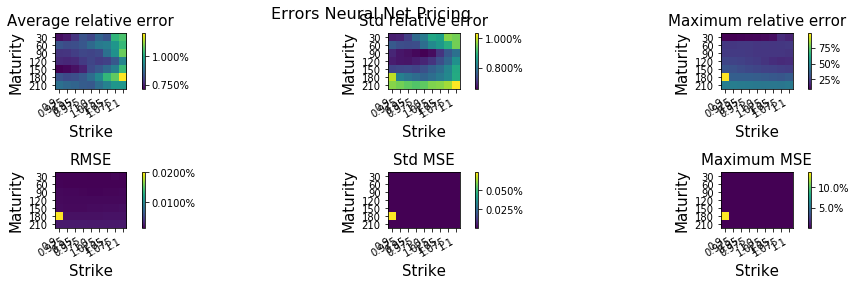

In [3]:
err_rel_mat,err_mat,idx,bad_idx = pricing_plotter(prediction,y_test_re)

# 2.2 CNN as Encoder / Vola Kernel with riskfree rate]

In [4]:
NN1a = Sequential() 
NN1a.add(InputLayer(input_shape=(Nparameters+Nmaturities,1,1,)))
NN1a.add(ZeroPadding2D(padding=(0, 2)))
NN1a.add(Conv2D(32, (3, 1), padding='valid',use_bias =True,strides =(1,1),activation='elu'))#X_train_trafo.shape[1:],activation='elu'))
NN1a.add(ZeroPadding2D(padding=(1,1)))
NN1a.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(1,1),activation ='elu'))
NN1a.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1a.add(ZeroPadding2D(padding=(1,1)))
NN1a.add(Conv2D(32, (3,3),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1a.add(ZeroPadding2D(padding=(1,1)))
NN1a.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1a.add(ZeroPadding2D(padding=(1,1)))
NN1a.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
#NN1.add(MaxPooling2D(pool_size=(2, 1)))
#NN1.add(Dropout(0.25))
#NN1.add(ZeroPadding2D(padding=(0,1)))
NN1a.add(Conv2D(Nstrikes, (2, 1),padding='valid',use_bias =True,strides =(2,1),activation ='linear', kernel_constraint = tf.keras.constraints.NonNeg()))
#NN1.add(MaxPooling2D(pool_size=(4, 1)))
NN1a.summary()

#setting
NN1a.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])
#NN1.compile(loss = "MSE", optimizer = "adam",metrics=["MAPE"])
inputs_train =np.concatenate((X_train_trafo,rates_train.reshape((Ntrain,Nmaturities,1,1))),axis=1)
inputs_val = np.concatenate((X_val_trafo,rates_val.reshape((Nval,Nmaturities,1,1))),axis=1)
inputs_test = np.concatenate((X_test_trafo,rates_test.reshape((Ntest,Nmaturities,1,1))),axis=1)
#NN1a.fit(inputs_train, y_train_trafo1, batch_size=64, validation_data = (inputs_val, y_val_trafo1), epochs = 80, verbose = True, shuffle=1)
#NN1a.save_weights("pricerweights_riskfreerate_231046.h5")#id_3283354135d44b67_data_price_norm_231046clean
NN1a.load_weights("pricerweights_riskfreerate_231046.h5")#id_3283354135d44b67_data_price_norm_231046clean
#  Results 
S0=1.
y_test_re    = yinversetransform(y_test_trafo).reshape((Ntest,Nmaturities,Nstrikes))
prediction   = NN1a.predict(inputs_test).reshape((Ntest,Nmaturities,Nstrikes))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_5 (ZeroPaddin (None, 12, 5, 1)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 5, 32)         128       
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 12, 7, 32)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 6, 32)         4128      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 5, 5, 32)          4128      
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 5, 32)         

### Plots

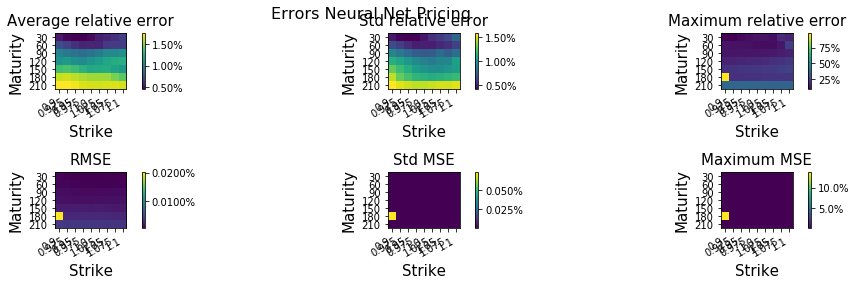

In [5]:
err_rel_mat,err_mat,idx,bad_idx = pricing_plotter(prediction,y_test_re)

# 2.3 CNN as Encoder / Pricing Kernel with riskfree rate

In [6]:
NN1b = Sequential() 
NN1b.add(InputLayer(input_shape=(Nparameters+Nmaturities,1,1,)))
NN1b.add(ZeroPadding2D(padding=(0, 2)))
NN1b.add(Conv2D(32, (3, 1), padding='valid',use_bias =True,strides =(1,1),activation='elu'))#X_train_trafo.shape[1:],activation='elu'))
NN1b.add(ZeroPadding2D(padding=(1,1)))
NN1b.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(1,1),activation ='elu'))
NN1b.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1b.add(ZeroPadding2D(padding=(1,1)))
NN1b.add(Conv2D(32, (3,3),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1b.add(ZeroPadding2D(padding=(1,1)))
NN1b.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1b.add(ZeroPadding2D(padding=(1,1)))
NN1b.add(Conv2D(32, (2, 2),padding='valid',use_bias =False,strides =(2,1),activation ='elu'))
#NN1.add(MaxPooling2D(pool_size=(2, 1)))
#NN1.add(Dropout(0.25))
#NN1.add(ZeroPadding2D(padding=(0,1)))
NN1b.add(Conv2D(Nstrikes, (2, 1),padding='valid',use_bias =False,strides =(2,1),activation ='tanh', kernel_constraint = tf.keras.constraints.NonNeg()))
#NN1.add(MaxPooling2D(pool_size=(4, 1)))
NN1b.summary()

#setting
#NN1b.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])
NN1b.compile(loss = "MSE", optimizer = "adam",metrics=["MAPE"])
inputs_train =np.concatenate((X_train_trafo,rates_train.reshape((Ntrain,Nmaturities,1,1))),axis=1)
inputs_val = np.concatenate((X_val_trafo,rates_val.reshape((Nval,Nmaturities,1,1))),axis=1)
inputs_test = np.concatenate((X_test_trafo,rates_test.reshape((Ntest,Nmaturities,1,1))),axis=1)
#NN1b.fit(inputs_train, y_train_trafo1, batch_size=64, validation_data = (inputs_val, y_val_trafo1_price),epochs = 80, verbose = True, shuffle=1)
#NN1b.save_weights("pricerweights_riskfreerate_price_231046.h5")#id_3283354135d44b67_data_price_norm_231046clean
NN1b.load_weights("pricerweights_riskfreerate_price_231046.h5")#id_3283354135d44b67_data_price_norm_231046clean


#  Results 
# The following plots show the performance on the testing set
S0=1.
y_test_re    = yinversetransform(y_test_trafo_price,0).reshape((Ntest,Nmaturities,Nstrikes))
prediction   = NN1b.predict(inputs_test).reshape((Ntest,Nmaturities,Nstrikes))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_10 (ZeroPaddi (None, 12, 5, 1)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 10, 5, 32)         128       
_________________________________________________________________
zero_padding2d_11 (ZeroPaddi (None, 12, 7, 32)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 11, 6, 32)         4128      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 5, 5, 32)          4128      
_________________________________________________________________
zero_padding2d_12 (ZeroPaddi (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 3, 5, 32)         

### Plots

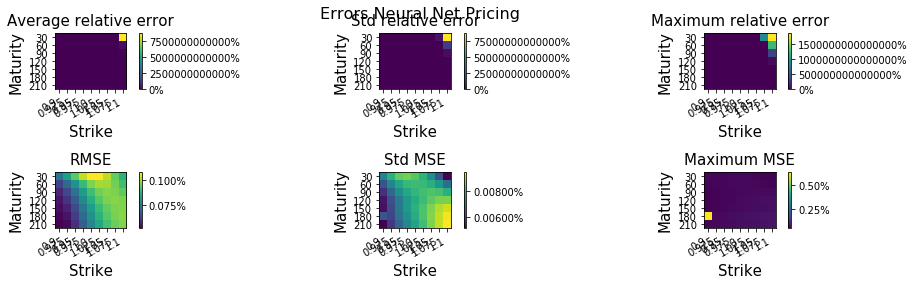

In [7]:
err_rel_mat,err_mat,idx,bad_idx = pricing_plotter(prediction,y_test_re)

# 2.4 CNN as Encoder / Pricing Kernel with no riskfree rate]:

In [8]:
NN1c = Sequential() 

NN1c.add(InputLayer(input_shape=(Nparameters,1,1,)))
NN1c.add(ZeroPadding2D(padding=(2, 2)))
NN1c.add(Conv2D(32, (3, 1), padding='valid',use_bias =True,strides =(1,1),activation='elu'))#X_train_trafo.shape[1:],activation='elu'))
#NN1c.add(Dropout(0.25))

NN1c.add(ZeroPadding2D(padding=(1,1)))
NN1c.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(1,1),activation ='elu'))
NN1c.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1c.add(ZeroPadding2D(padding=(1,1)))
NN1c.add(Conv2D(32, (3,3),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1c.add(ZeroPadding2D(padding=(1,1)))
NN1c.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1c.add(ZeroPadding2D(padding=(1,1)))
NN1c.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
#NN1c.add(MaxPooling2D(pool_size=(2, 1)))
#NN1c.add(Dropout(0.25))
#NN1c.add(ZeroPadding2D(padding=(0,1)))
NN1c.add(Conv2D(Nstrikes, (2, 1),padding='valid',use_bias =True,strides =(2,1),activation ='tanh', kernel_constraint = tf.keras.constraints.NonNeg()))
#NN1c.add(MaxPooling2D(pool_size=(4, 1)))
NN1c.summary()
#setting
NN1c.compile(loss = "MSE", optimizer = "adam",metrics=["MAPE"])
#NN1c.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])
tmp_train = np.argsort(np.min(y_train_price,axis=1))
tmp_test = np.argsort(np.min(y_test_price,axis=1))
tmp_val = np.argsort(np.min(y_val_price,axis=1))
y_train_tmp = y_train_trafo1_price[tmp_train[4000:],:,:,:]
y_val_tmp = y_val_trafo1_price[tmp_val[1500:],:,:,:]
y_test_tmp =  y_test_trafo1_price[tmp_test[1500:],:,:,:]
X_train_tmp = X_train_trafo[tmp_train[4000:],:,:,:]
X_val_tmp = X_val_trafo[tmp_val[1500:],:,:,:]
X_test_tmp = X_test_trafo[tmp_test[1500:],:,:,:]
#NN1c.fit(X_train_tmp, y_train_tmp, batch_size=64, validation_data = (X_val_tmp, y_val_tmp), epochs = 300, verbose = True, shuffle=1)
#NN1c.fit(X_train_trafo, y_train_trafo1, batch_size=64, validation_data = (X_val_trafo, y_val_trafo1_price), epochs = 80, verbose = True, shuffle=1)
#NN1c.save_weights("pricerweights_noriskfreerate_price_231046.h5")#id_3283354135d44b67_data_price_norm_231046clean
NN1c.load_weights("pricerweights_noriskfreerate_price_231046.h5")#id_3283354135d44b67_data_price_norm_231046clean
#  Results 
# The following plots show the performance on the testing set
S0=1.
#y_test_re    = yinversetransform(y_test_tmp,0).reshape((Ntest-1500,Nmaturities,Nstrikes))
#prediction   = NN1c.predict(X_test_tmp).reshape((Ntest-1500,Nmaturities,Nstrikes))
y_test_re    = yinversetransform(y_test_trafo_price).reshape((Ntest,Nmaturities,Nstrikes))
prediction   = NN1c.predict(X_test_trafo).reshape((Ntest,Nmaturities,Nstrikes))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_15 (ZeroPaddi (None, 9, 5, 1)           0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 5, 32)          128       
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 9, 7, 32)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 6, 32)          4128      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 5, 32)          4128      
_________________________________________________________________
zero_padding2d_17 (ZeroPaddi (None, 6, 7, 32)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 2, 5, 32)         

### Plots

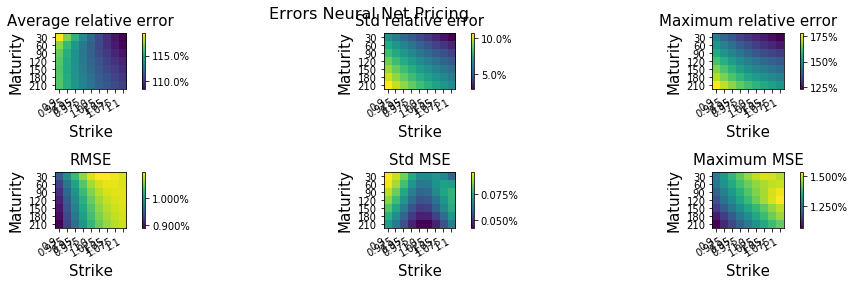

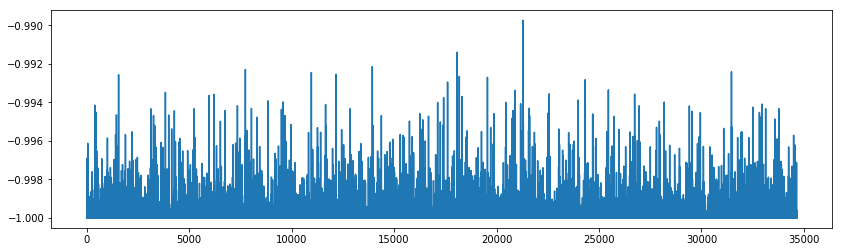

In [10]:
err_rel_mat,err_mat,idx,bad_idx = pricing_plotter(prediction,y_test_re)
err_matrix = np.mean(err_rel_mat,axis=(1,2))
err_idx = np.argsort(err_matrix)
plt.figure(figsize= (14,4))
plt.plot(np.min(y_test_re,axis=(1,2)))
#plt.plot(err_matrix)
plt.show()

# 2.4 CNN as Encoder / Vola and Pricing Kernelsimultaniously with no riskfree rate]:

In [ ]:
#tf.config.experimental_run_functions_eagerly(False)
y_train_comb = np.concatenate((y_train_trafo2,y_train_trafo2_price),axis = 3)
y_test_comb = np.concatenate((y_test_trafo2,y_test_trafo2_price),axis = 3)
y_val_comb = np.concatenate((y_val_trafo2,y_val_trafo2_price),axis = 3)

y_train_comb1 = np.concatenate((y_train_trafo1,y_train_trafo1_price),axis = 1)
y_test_comb1 = np.concatenate((y_test_trafo1,y_test_trafo1_price),axis = 1)
y_val_comb1 = np.concatenate((y_val_trafo1,y_val_trafo1_price),axis = 1)
NN1comb = Sequential() 
NN1comb.add(InputLayer(input_shape=(Nparameters,)))
NN1comb.add(Dense(10,activation = "elu",use_bias=True))
NN1comb.add(Dense(30,activation = "elu",use_bias=True))
NN1comb.add(Dense(60,activation = "elu",use_bias=True))
NN1comb.add(Dense(120,activation = "elu",use_bias=True))
NN1comb.add(Reshape((15, 2,4), input_shape=(120,)))
NN1comb.add(ZeroPadding2D(padding=(2, 2)))
NN1comb.add(Conv2D(8, (3, 1), padding='valid',use_bias =True,strides =(1,1),activation='elu'))#X_train_trafo.shape[1:],activation='elu'))
NN1comb.add(ZeroPadding2D(padding=(2, 2)))
NN1comb.add(Conv2D(30, (3, 3), padding='valid',use_bias =True,strides =(1,1),activation='elu'))#X_train_trafo.shape[1:],activation='elu'))
NN1comb.add(Conv2D(30, (3, 3), padding='valid',use_bias =True,strides =(2,1),activation='elu'))#X_train_trafo.shape[1:],activation='elu'))
NN1comb.add(ZeroPadding2D(padding=(1,1)))
NN1comb.add(Conv2D(10, (2, 2),padding='valid',use_bias =True,strides =(1,1),activation ='elu'))
NN1comb.add(Conv2D(9, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1comb.add(ZeroPadding2D(padding=(1,1)))
NN1comb.add(Conv2D(9, (3,3),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1comb.add(ZeroPadding2D(padding=(1,1)))
NN1comb.add(Conv2D(9, (3, 3),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1comb.add(ZeroPadding2D(padding=(1,1)))
NN1comb.add(Conv2D(9, (2, 3),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1comb.add(ZeroPadding2D(padding=(1,1)))
NN1comb.add(Conv2D(9, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
#NN1.add(MaxPooling2D(pool_size=(2, 1)))
#NN1.add(Dropout(0.25))
#NN1.add(ZeroPadding2D(padding=(0,1)))
#NN1comb.add(Conv2D(Nstrikes, (1, 1),padding='valid',use_bias =True,strides =(2,1),activation ='linear', kernel_constraint = tf.keras.constraints.NonNeg()))
#NN1.add(MaxPooling2D(pool_size=(4, 1)))
NN1comb.summary()
#setting
NN1comb.compile(loss = "MSE", optimizer = "adam",metrics=["MAPE"])
#NN1comb.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])
#NN1comb.fit(X_train_trafo, y_train_trafo1, batch_size=64, validation_data = (X_val_trafo, y_val_trafo1), epochs = 300, verbose = True, shuffle=1)
NN1comb.fit(X_train_trafo.reshape((Ntrain,Nparameters)), y_train_comb1, batch_size=64, validation_data = (X_val_trafo.reshape((Nval,Nparameters)), y_val_comb1), epochs = 80, verbose = True, shuffle=1)
NN1comb.save_weights("pricerweights_comb_231046.h5")#id_3283354135d44b67_data_price_norm_231046clean
NN1comb.load_weights("pricerweights_comb_231046.h5")#id_3283354135d44b67_data_price_norm_231046clean


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_5 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_6 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_7 (Dense)              (None, 120)               7320      
_________________________________________________________________
reshape_1 (Reshape)          (None, 15, 2, 4)          0         
_________________________________________________________________
zero_padding2d_32 (ZeroPaddi (None, 19, 6, 4)          0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 17, 6, 8)         

### Plots

# 3.1 CNN as  Decoder/Inverse Mapping / Calibration

In [31]:
NN2 = Sequential() 
NN2.add(InputLayer(input_shape=(Nmaturities,Nstrikes,1)))
NN2.add(Conv2D(64,(3, 3),use_bias= True, padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(MaxPooling2D(pool_size=(2, 2)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(Flatten())
NN2.add(Dense(Nparameters,activation = 'linear',use_bias=True))
NN2.summary()
#NN2.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])

#setting
NN2.compile(loss =mse_constraint(0.25), optimizer = "adam",metrics=["MAPE", "MSE"])
#history = NN2.fit(y_train_trafo2,X_train_trafo2, batch_size=50, validation_data = (y_val_trafo2,X_val_trafo2), epochs=40, verbose = True, shuffle=1)
#NN2.save_weights("calibrationweights_231046.h5")#id_3283354135d44b67_data_price_norm_231046clean
NN2.load_weights("calibrationweights_231046.h5")#id_3283354135d44b67_data_price_norm_231046clean



Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 5, 7, 64)          640       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 4, 6, 64)          16448     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 3, 64)          0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 1, 2, 64)          16448     
_________________________________________________________________
zero_padding2d_32 (ZeroPaddi (None, 3, 4, 64)          0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 2, 3, 64)          16448     
_________________________________________________________________
zero_padding2d_33 (ZeroPaddi (None, 4, 5, 64)         

### Plots

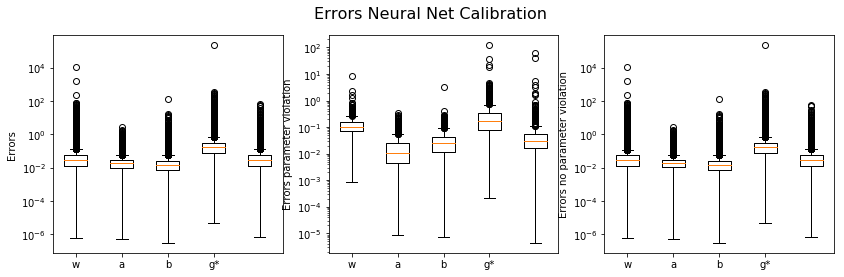

violation error mean in %: [14.18381537  2.26137178  4.25215267 54.91945722 21.20136247]
no violation error mean in %: [ 48.33431919   2.88700727   3.4130751  713.2159498    7.03259563]
violation error median in %: [10.14839695  1.06705544  2.61026004 16.75316181  3.10315469]
no violation error median in %: [ 2.78550845  1.94562492  1.50999647 17.20481463  2.79344062]
error mean in %: [ 47.57754316   2.87314317   3.43166908 698.62808281   7.34657587]
error median in %: [ 2.8668843   1.92884309  1.52307384 17.19508696  2.80101632]


ValueError: cannot reshape array of size 173285 into shape (51018,5,1,1)

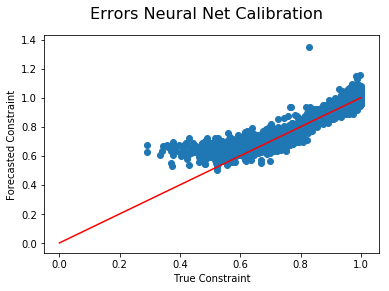

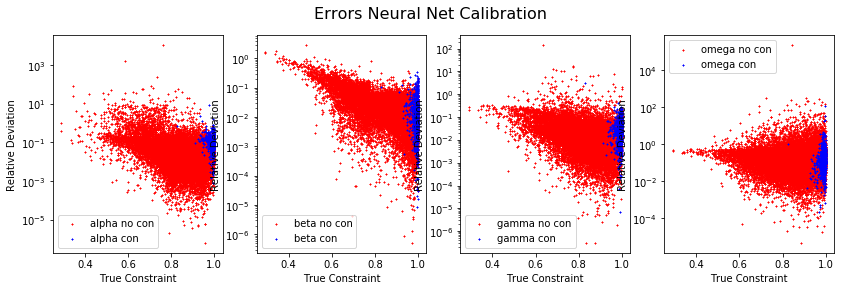

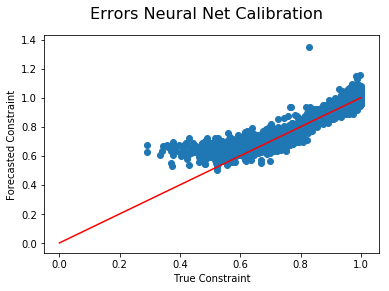

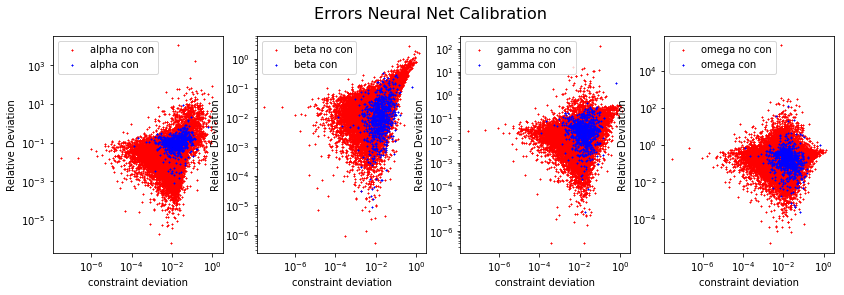

In [33]:
from add_func_latent import calibration_plotter
prediction_calibration = NN2.predict(y_test_trafo2)
prediction_invtrafo= np.array([myinverse(x) for x in prediction_calibration])

#plots
error,err1,err2,vio_error,vio_error2,c,c2,testing_violation,testing_violation2 = calibration_plotter(prediction_calibration,X_test_trafo2,X_test)

# ### 3.2 Testing the performace of the AutoEncoder/Decoder Combination
# We test how the two previously trained NN work together. First, HNG-Vola surfaces are used to predict the underlying parameters with NN2. Those predictions are fed into NN1 to get Vola-Surface again. The results are shown below.

forecast = autoencoder(NN1,NN2)(y_test_trafo2)
#prediction = NN2.predict(y_test_trafo2)
#prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
#forecast = NN1.predict(prediction_trafo).reshape(Ntest,Nmaturities,Nstrikes)
y_true_test = y_test_trafo2.reshape(Ntest,Nmaturities,Nstrikes)
mape_autoencoder,mse_autoencoder = plotter_autoencoder(forecast,y_true_test,y_test,testing_violation,testing_violation2)




# 3.2 CNN as  Decoder/Inverse Mapping / Calibration TANHELU


In [12]:
NN2c = Sequential() 
NN2c.add(InputLayer(input_shape=(Nmaturities,Nstrikes,1)))
NN2c.add(Conv2D(12,(3, 3),use_bias= True, padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(Conv2D(24,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(MaxPooling2D(pool_size=(2, 2)))
NN2c.add(Conv2D(32,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(ZeroPadding2D(padding=(1,1)))
NN2c.add(Conv2D(32,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(ZeroPadding2D(padding=(1,1)))
NN2c.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(ZeroPadding2D(padding=(1,1)))
NN2c.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(ZeroPadding2D(padding=(1,1)))
NN2c.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(Flatten())
NN2c.add(Dense(Nparameters,activation = "tanh", kernel_constraint = tf.keras.constraints.NonNeg(),use_bias=True))
NN2c.summary()

#NN2.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])

#setting
#NN2c.compile(loss =mse_constraint(0.25), optimizer = "adam",metrics=["MAPE", "MSE"])
#history = NN2c.fit(y_train_trafo2,X_train_trafo2, batch_size=50, validation_data = (y_val_trafo2,X_val_trafo2),
#    epochs=300, verbose = True, shuffle=1)
#NN2.save_weights("calibrationweights_elutanh.h5")
NN2c.load_weights("calibrationweights_elutanh.h5")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 5, 7, 12)          120       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 4, 6, 24)          1176      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 3, 24)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 1, 2, 32)          3104      
_________________________________________________________________
zero_padding2d_24 (ZeroPaddi (None, 3, 4, 32)          0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 2, 3, 32)          4128      
_________________________________________________________________
zero_padding2d_25 (ZeroPaddi (None, 4, 5, 32)         

### Plots

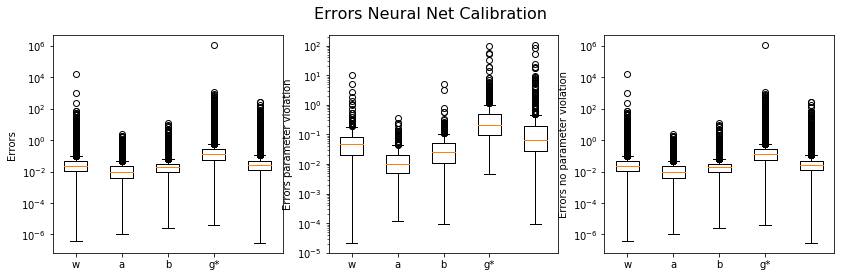

violation error mean in %: [ 12.1192687    1.87534452   6.34906548 125.58688052 115.01152267]
no violation error mean in %: [6.11745594e+01 2.29813938e+00 2.76966432e+00 3.26715711e+03
 1.01463327e+01]
violation error median in %: [ 4.6786187   1.0405032   2.52522048 21.65931174  6.74277118]
no violation error median in %: [ 2.29798398  0.95576671  1.9931863  12.53317675  2.6359253 ]
error mean in %: [6.05701617e+01 2.29293023e+00 2.81376520e+00 3.22845063e+03
 1.14383497e+01]
error median in %: [ 2.31225589  0.95662117  1.99694971 12.60059789  2.65630727]


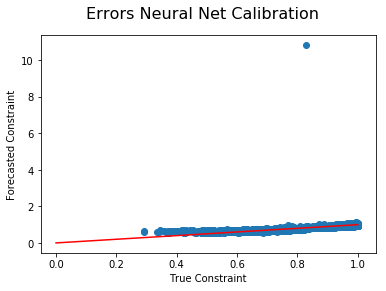

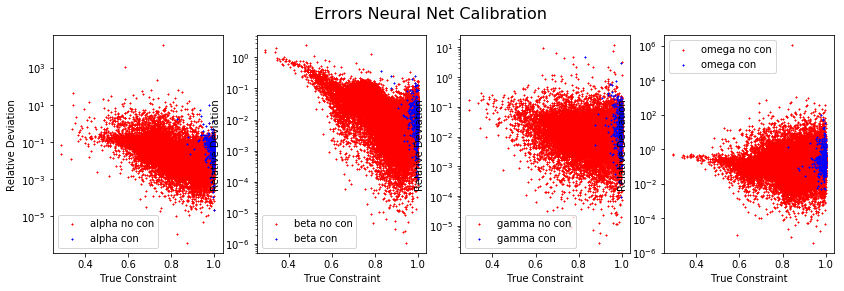

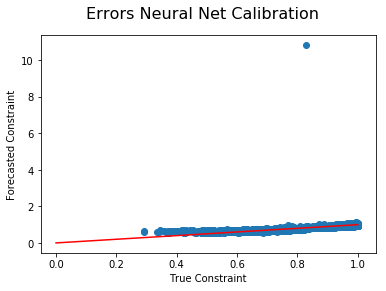

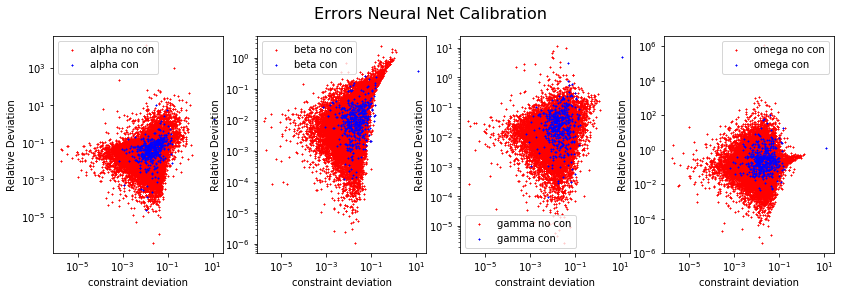

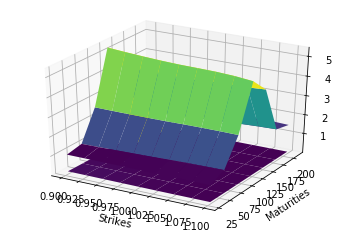

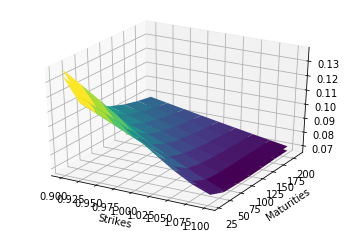

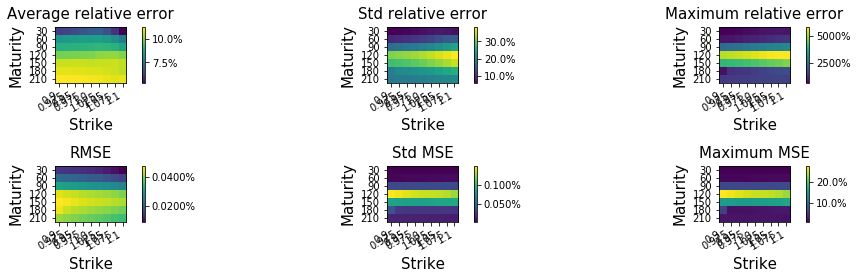

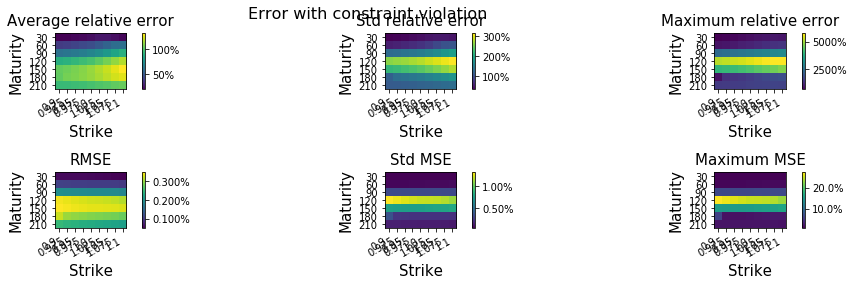

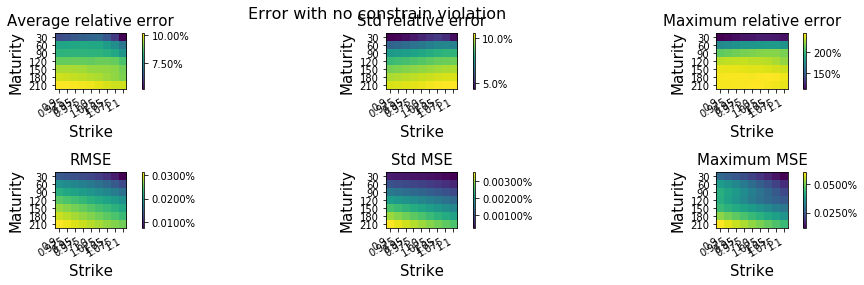

In [14]:
# ### 5.1 Results

# In[10]:



from add_func_latent import calibration_plotter
prediction_calibration = NN2c.predict(y_test_trafo2)
prediction_invtrafo= np.array([myinverse(x) for x in prediction_calibration])

#plots
error,err1,err2,vio_error,vio_error2,c,c2,testing_violation,testing_violation2 = calibration_plotter(prediction_calibration,X_test_trafo2,X_test)

# In[Testing the performace of the AutoEncoder/Decoder Combination]
# We test how the two previously trained NN work together. First, HNG-Vola surfaces are used to predict the underlying parameters with NN2. Those predictions are fed into NN1 to get Vola-Surface again. The results are shown below.


forecast = autoencoder(NN1,NN2c)(y_test_trafo2)
#prediction = NN2.predict(y_test_trafo2)
#prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
#forecast = NN1.predict(prediction_trafo).reshape(Ntest,Nmaturities,Nstrikes)
y_true_test = y_test_trafo2.reshape(Ntest,Nmaturities,Nstrikes)
mape_autoencoder,mse_autoencoder = plotter_autoencoder(forecast,y_true_test,y_test,testing_violation,testing_violation2)



# 4. Inverse Autoencoder params surface params

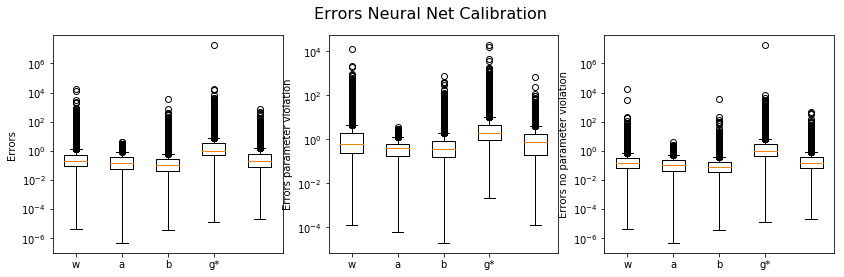

violation error mean in %: [ 636.60939721   40.45136776  125.66951398 1426.9886405   157.25438287]
no violation error mean in %: [1.21580726e+02 1.76889387e+01 3.47026004e+01 6.85928522e+04
 5.50909620e+01]
violation error median in %: [ 61.69494374  41.53318732  37.05632792 188.7533925   73.6979262 ]
no violation error median in %: [15.08860701  9.77776306  7.77404611 92.02481604 14.63986355]
error mean in %: [2.48283397e+02 2.32887445e+01 5.70814533e+01 5.20693172e+04
 8.02242778e+01]
error median in %: [19.87180555 13.4073612  10.78061207 99.80770382 18.79456867]


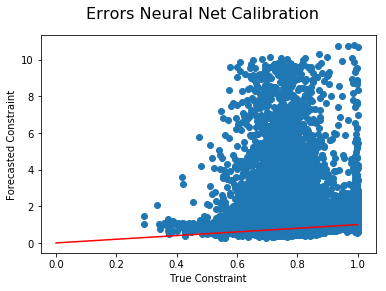

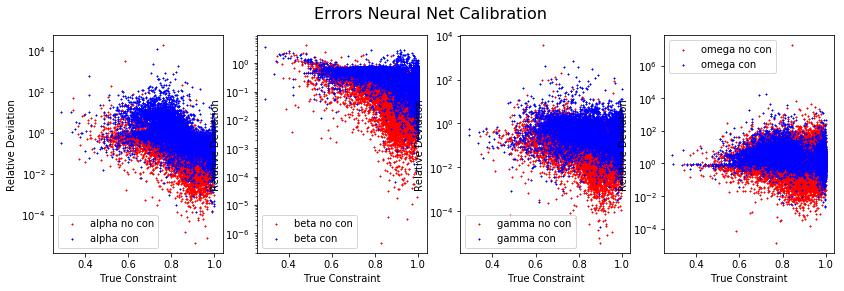

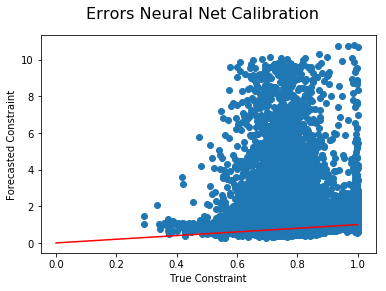

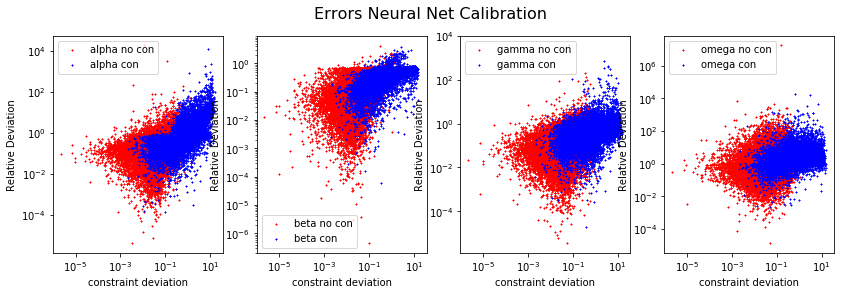

In [24]:
predict_y = NN1.predict(X_test_trafo).reshape((Ntest,Nmaturities,Nstrikes,1))
prediction_x = NN2c.predict(predict_y)
prediction_invtrafo= np.array([myinverse(x) for x in prediction_x])
for i in range(Ntest):
    error[i,:] =  np.abs((X_test[i,:]-prediction_invtrafo[i,:])/X_test[i,:])
err1 = np.mean(error,axis = 0)
err2 = np.median(error,axis = 0)
err_std = np.std(error,axis = 0)
idx = np.argsort(error[:,0], axis=None)
_,_,c =constraint_violation(prediction_invtrafo)
_,_,c2 =constraint_violation(X_test)
testing_violation = c>=1
testing_violation2 = (c<1)
vio_error = error[testing_violation,:]
vio_error2 = error[testing_violation2,:]


plt.figure(figsize=(14,4))
plt.suptitle('Errors Neural Net Calibration', fontsize=16)
ax=plt.subplot(1,3,1)
plt.boxplot(error)
plt.yscale("log")
plt.xticks([1, 2, 3,4], ['w','a','b','g*'])
plt.ylabel("Errors")
ax=plt.subplot(1,3,2)
plt.boxplot(vio_error)
plt.yscale("log")
plt.xticks([1, 2, 3,4], ['w','a','b','g*'])
plt.ylabel("Errors parameter violation")
ax=plt.subplot(1,3,3)
plt.boxplot(vio_error2)
plt.yscale("log")
plt.xticks([1, 2, 3,4], ['w','a','b','g*'])
plt.ylabel("Errors no parameter violation")
plt.show()

print("violation error mean in %:",100*np.mean(vio_error,axis=0))
print("no violation error mean in %:",100*np.mean(vio_error2,axis=0))
print("violation error median in %:",100*np.median(vio_error,axis=0))
print("no violation error median in %:",100*np.median(vio_error2,axis=0))
print("error mean in %:",100*err1)
print("error median in %:",100*err2)

fig = plt.figure()
plt.suptitle('Errors Neural Net Calibration', fontsize=16)
plt.scatter(c2,c)
plt.plot(np.arange(0, 1.1,0.5),np.arange(0,1.1,0.5),'-r')
plt.xlabel("True Constraint")
plt.ylabel("Forecasted Constraint")


plt.figure(figsize=(14,4))
plt.suptitle('Errors Neural Net Calibration', fontsize=16)
ax=plt.subplot(1,4,1)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,0],c="r",s=1,marker="x",label="alpha no con")
plt.scatter(c2[testing_violation],vio_error[:,0],c="b",s=1,marker="x",label="alpha con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,4,2)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,1],c="r",s=1,marker="x",label="beta no con")
plt.scatter(c2[testing_violation],vio_error[:,1],c="b",s=1,marker="x",label="beta con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,4,3)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,2],c="r",s=1,marker="x",label="gamma no con")
plt.scatter(c2[testing_violation],vio_error[:,2],c="b",s=1,marker="x",label="gamma con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,4,4)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,3],c="r",s=1,marker="x",label="omega no con")
plt.scatter(c2[testing_violation],vio_error[:,3],c="b",s=1,marker="x",label="omega con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()


fig = plt.figure()
plt.suptitle('Errors Neural Net Calibration', fontsize=16)
plt.scatter(c2,c)
plt.plot(np.arange(0, 1.1,0.5),np.arange(0, 1.1,0.5),'-r')
plt.xlabel("True Constraint")
plt.ylabel("Forecasted Constraint")

plt.figure(figsize=(14,4))
plt.suptitle('Errors Neural Net Calibration', fontsize=16)
ax=plt.subplot(1,4,1)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,0],c="r",s=1,marker="x",label="alpha no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,0],c="b",s=1,marker="x",label="alpha con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,4,2)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,1],c="r",s=1,marker="x",label="beta no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,1],c="b",s=1,marker="x",label="beta con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,4,3)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,2],c="r",s=1,marker="x",label="gamma no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,2],c="b",s=1,marker="x",label="gamma con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,4,4)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,3],c="r",s=1,marker="x",label="omega no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,3],c="b",s=1,marker="x",label="omega con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()

### Plots

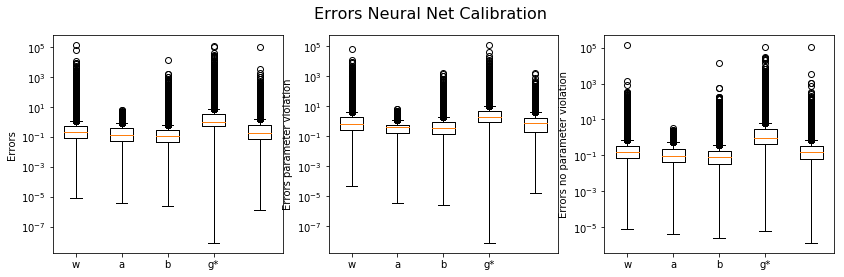

violation error mean in %: [ 825.13146874   40.70114446  119.33267757 1525.32412713  163.72991494]
no violation error mean in %: [150.20591117  17.63626103  33.53246152 876.05899835 141.45174593]
violation error median in %: [ 63.36719966  42.28382731  36.78915103 198.17060551  76.58444363]
no violation error median in %: [15.01573813  9.72627108  7.75790351 92.38081941 14.56585812]
error mean in %: [ 318.47031499   23.38652314   54.92314978 1037.92604959  147.00587377]
error median in %: [ 19.94773475  13.43158758  10.67382449 103.49106722  18.78617935]


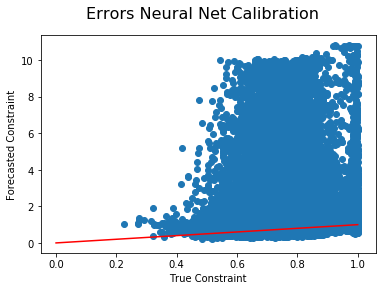

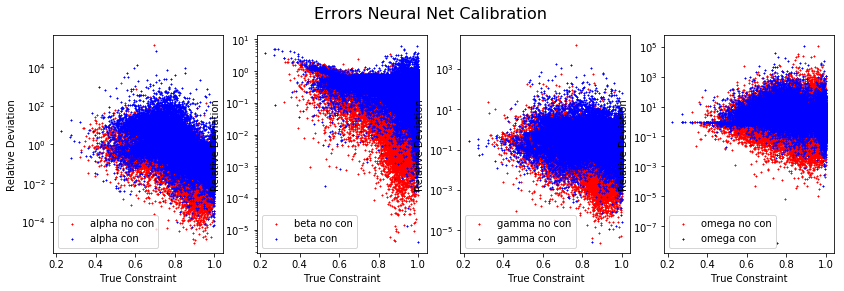

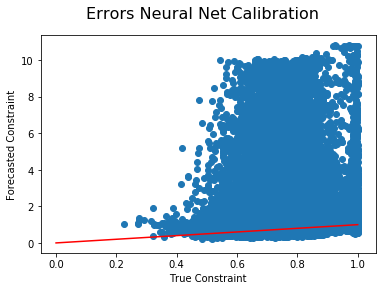

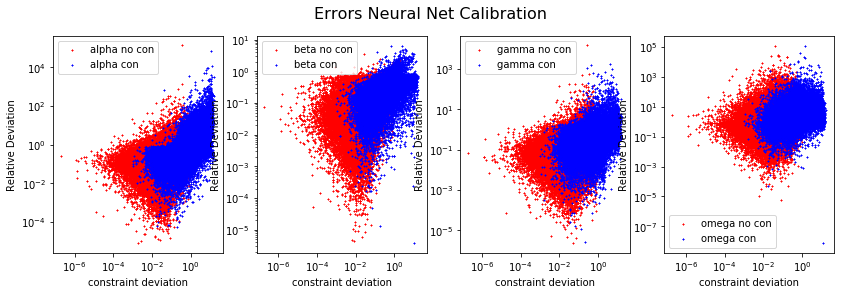

In [27]:
predict_y = NN1.predict(X_train_trafo).reshape((Ntrain,Nmaturities,Nstrikes,1))
prediction_x = NN2c.predict(predict_y)
prediction_invtrafo= np.array([myinverse(x) for x in prediction_x])
error = np.zeros((Ntrain,Nparameters))
for i in range(Ntrain):
    error[i,:] =  np.abs((X_train[i,:]-prediction_invtrafo[i,:])/X_train[i,:])
err1 = np.mean(error,axis = 0)
err2 = np.median(error,axis = 0)
err_std = np.std(error,axis = 0)
idx = np.argsort(error[:,0], axis=None)
_,_,c =constraint_violation(prediction_invtrafo)
_,_,c2 =constraint_violation(X_train)
testing_violation = c>=1
testing_violation2 = (c<1)
vio_error = error[testing_violation,:]
vio_error2 = error[testing_violation2,:]


plt.figure(figsize=(14,4))
plt.suptitle('Errors Neural Net Calibration', fontsize=16)
ax=plt.subplot(1,3,1)
plt.boxplot(error)
plt.yscale("log")
plt.xticks([1, 2, 3,4], ['w','a','b','g*'])
plt.ylabel("Errors")
ax=plt.subplot(1,3,2)
plt.boxplot(vio_error)
plt.yscale("log")
plt.xticks([1, 2, 3,4], ['w','a','b','g*'])
plt.ylabel("Errors parameter violation")
ax=plt.subplot(1,3,3)
plt.boxplot(vio_error2)
plt.yscale("log")
plt.xticks([1, 2, 3,4], ['w','a','b','g*'])
plt.ylabel("Errors no parameter violation")
plt.show()

print("violation error mean in %:",100*np.mean(vio_error,axis=0))
print("no violation error mean in %:",100*np.mean(vio_error2,axis=0))
print("violation error median in %:",100*np.median(vio_error,axis=0))
print("no violation error median in %:",100*np.median(vio_error2,axis=0))
print("error mean in %:",100*err1)
print("error median in %:",100*err2)

fig = plt.figure()
plt.suptitle('Errors Neural Net Calibration', fontsize=16)
plt.scatter(c2,c)
plt.plot(np.arange(0, 1.1,0.5),np.arange(0,1.1,0.5),'-r')
plt.xlabel("True Constraint")
plt.ylabel("Forecasted Constraint")


plt.figure(figsize=(14,4))
plt.suptitle('Errors Neural Net Calibration', fontsize=16)
ax=plt.subplot(1,4,1)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,0],c="r",s=1,marker="x",label="alpha no con")
plt.scatter(c2[testing_violation],vio_error[:,0],c="b",s=1,marker="x",label="alpha con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,4,2)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,1],c="r",s=1,marker="x",label="beta no con")
plt.scatter(c2[testing_violation],vio_error[:,1],c="b",s=1,marker="x",label="beta con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,4,3)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,2],c="r",s=1,marker="x",label="gamma no con")
plt.scatter(c2[testing_violation],vio_error[:,2],c="b",s=1,marker="x",label="gamma con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,4,4)
plt.yscale("log")
plt.scatter(c2[testing_violation2],vio_error2[:,3],c="r",s=1,marker="x",label="omega no con")
plt.scatter(c2[testing_violation],vio_error[:,3],c="b",s=1,marker="x",label="omega con")
plt.xlabel("True Constraint")
plt.ylabel("Relative Deviation")
plt.legend()


fig = plt.figure()
plt.suptitle('Errors Neural Net Calibration', fontsize=16)
plt.scatter(c2,c)
plt.plot(np.arange(0, 1.1,0.5),np.arange(0, 1.1,0.5),'-r')
plt.xlabel("True Constraint")
plt.ylabel("Forecasted Constraint")

plt.figure(figsize=(14,4))
plt.suptitle('Errors Neural Net Calibration', fontsize=16)
ax=plt.subplot(1,4,1)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,0],c="r",s=1,marker="x",label="alpha no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,0],c="b",s=1,marker="x",label="alpha con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,4,2)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,1],c="r",s=1,marker="x",label="beta no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,1],c="b",s=1,marker="x",label="beta con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,4,3)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,2],c="r",s=1,marker="x",label="gamma no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,2],c="b",s=1,marker="x",label="gamma con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()
ax=plt.subplot(1,4,4)
plt.yscale("log")
plt.xscale("log")
plt.scatter(abs((c2[testing_violation2]-c[testing_violation2])/c2[testing_violation2]),vio_error2[:,3],c="r",s=1,marker="x",label="omega no con")
plt.scatter(abs((c2[testing_violation]-c[testing_violation])/c2[testing_violation]),vio_error[:,3],c="b",s=1,marker="x",label="omega con")
plt.xlabel("constraint deviation")
plt.ylabel("Relative Deviation")
plt.legend()

# 5. Different Datasets

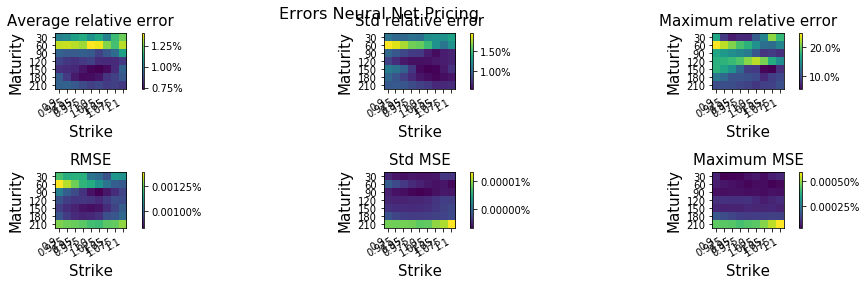

In [29]:
mat         = scipy.io.loadmat("id_8de7e9a278da4059_data_vola_unisymmetric_51018.mat")
data_vola2        = mat['data_vola']
mat         = scipy.io.loadmat("id_8de7e9a278da4059_data_price_unisymmetric_51018.mat")
data_price2       = mat['data_price']
Ntest2 = Ntest
Ntest =51018
xx2 = data_vola2 [:,:Nparameters]
yy2 = data_vola2[:,Nparameters+Nmaturities:]
yy2_price =data_price2[:,Nparameters+Nmaturities:]
rates2 =data_vola2[:,Nparameters:Nparameters+Nmaturities]
y_vola2  = np.asarray([yy2[i,:].reshape((1,Nmaturities,Nstrikes)) for i in range(Ntest)])  
X2 = np.array([myscale(x) for x in xx2])
S0=1.
y_test_re    = yinversetransform(y_vola2).reshape((Ntest,Nmaturities,Nstrikes))
prediction   = NN1.predict(X2.reshape((Ntest,Nparameters,1,1))).reshape((Ntest,Nmaturities,Nstrikes))
err_rel_mat,err_mat,idx,bad_idx = pricing_plotter(prediction,y_test_re)